In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#pip install scikit-learn

In [3]:
import sklearn
from sklearn import linear_model

In [4]:
from scipy.io import mmread

In [5]:
df_excel   = pd.read_excel("data/1100_2017-Strukturdaten_Data_D_F_v1.1.0.xlsx", header=1, skiprows=1)
df_msrid   = pd.read_excel("data/1100_2017-Strukturdaten_Data_D_F_v1.1.0.xlsx", header=1, skiprows=0, sheet_name=2)
df_cantid  = pd.read_excel("data/1100_2017-Strukturdaten_Data_D_F_v1.1.0.xlsx", header=1, skiprows=0, sheet_name=3)

In [6]:
# Merge msrname and cantname in main DF
df_strukturdaten = df_excel
df_strukturdaten = df_strukturdaten.merge(df_msrid, left_on='msrid'  , right_on='Code').drop(columns=['Code']).rename(columns={"Label": "Municipality"})
df_strukturdaten = df_strukturdaten.merge(df_cantid, left_on='cantid', right_on='Code').drop(columns=['Code']).rename(columns={"Label": "Canton"})
#filtering out 'X' records, dataframe has X where column r has X.
df_strukturdaten = df_strukturdaten[df_strukturdaten.r != 'X']

In [7]:
df_strukturdaten.head()

,npvmid,N_Gem,munid,msrid,cantid,r,re,r_age,R_0017_CARNOTC,R_1824_CARNOTC,...,students,airport_passengers,e_e,e_m,e_cb,fte_e,fte_m,fte_cb,Municipality,Canton
0,101001,Aeugst am Albis,1,4,1,1949,1173,43,0,78,...,0,0,211,254,0,126,184,0,Knonaueramt,Zürich
1,201001,Affoltern am Albis,2,4,1,1238,746,40,0,59,...,0,0,160,141,0,106,110,0,Knonaueramt,Zürich
2,201002,Affoltern am Albis,2,4,1,407,139,49,0,10,...,0,0,1688,822,10,1305,738,8,Knonaueramt,Zürich
3,201003,Affoltern am Albis,2,4,1,1314,721,44,0,41,...,0,0,246,129,1,166,103,1,Knonaueramt,Zürich
4,201004,Affoltern am Albis,2,4,1,1195,564,44,0,36,...,0,0,568,335,0,419,279,0,Knonaueramt,Zürich


In [8]:
df_strukturdaten.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7752 entries, 0 to 7965
Columns: 156 entries, npvmid to Canton
dtypes: int64(36), object(120)
memory usage: 9.3+ MB


In [9]:
df_strukturdaten.describe(include='all').round(decimals=2).T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
npvmid,7752.0,NaN,NaN,NaN,303489424.72,223010247.79,101001.0,85276001.25,283151007.5,520351001.0,834202072.0
N_Gem,7752,2279,Zürich,289,NaN,NaN,NaN,NaN,NaN,NaN,NaN
munid,7752.0,NaN,NaN,NaN,3034.16,2229.29,1.0,852.75,2831.0,5202.25,6810.0
msrid,7752.0,NaN,NaN,NaN,51.74,33.59,1.0,20.0,49.0,82.0,106.0
cantid,7752.0,NaN,NaN,NaN,12.62,8.82,1.0,2.0,13.0,21.0,26.0
...,...,...,...,...,...,...,...,...,...,...,...
fte_e,7752.0,NaN,NaN,NaN,278.98,377.52,0.0,66.0,159.0,340.0,7544.0
fte_m,7752.0,NaN,NaN,NaN,173.51,179.64,2.0,66.0,123.0,212.0,2745.0
fte_cb,7752.0,NaN,NaN,NaN,28.29,97.06,0.0,0.0,2.0,13.0,2230.0
Municipality,7752,106,Genève,336,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
#finding correlation between npvmid(zone id) and number of people with car and no subsription (all age groups)
df_heatmap = df_strukturdaten[['npvmid','R_1824_CARNOTC','R_2544_CARNOTC','R_4564_CARNOTC','R_6574_CARNOTC']].astype({'npvmid': 'int32'})
df_heatmap = df_heatmap[df_heatmap['R_1824_CARNOTC']!='X'].astype('int32')

<AxesSubplot:>

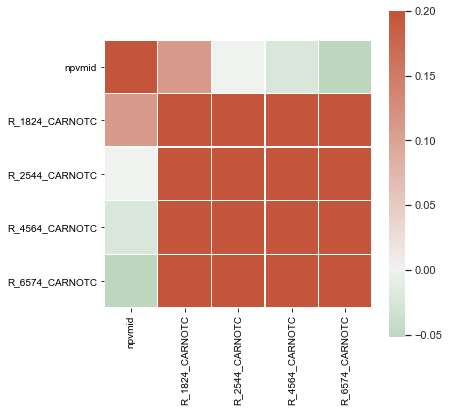

In [11]:
size = 6
figure, axes = plt.subplots(figsize=(size,size))

# pearson corellation
p_corr = df_heatmap.corr(method='pearson')
sns.set_theme(style="white")
cmap = sns.diverging_palette(130, 20, as_cmap=True)

sns.heatmap(p_corr, cmap=cmap, vmax=.2, center=0, square=True, linewidths=.3, ax=axes)

In [12]:
# find total SBB Subscriptions
# sum Halbtax + GA + other
column_names = ['R_HT','R_GATC','R_LTC']
df_strukturdaten['subs_total']= df_strukturdaten[column_names].sum(axis=1)

In [13]:
#relationship between average household income and number of subscriptions, in a zone.
df_regression1 = df_strukturdaten[['R_INCOME','subs_total']]

In [14]:
df_regression1 = df_regression1.rename({'R_INCOME':'Average_Income','subs_total':'Total_Abos'},axis=1).astype('int32')

In [15]:
x = df_regression1[df_regression1['Average_Income']!='X'].Average_Income.astype('int32')
y = df_regression1[df_regression1['Total_Abos']!='X'].Total_Abos.astype('int32')
x = x[:, None]

<ipython-input-15-f57c52eba7ed>:3: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, None]


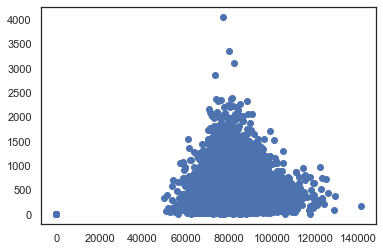

In [16]:
plt.scatter(x,y)

In [17]:
reg = linear_model.LinearRegression()
reg.fit(x, y)

LinearRegression()

In [18]:
w, w0 = reg.coef_, reg.intercept_
print(w, w0)

[0.00269839] 297.73894732490396


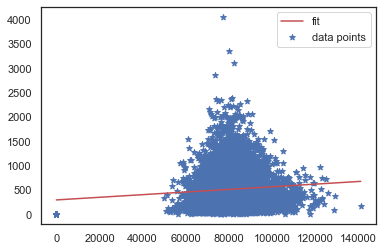

In [19]:
plt.scatter(x, y, marker='*', label='data points')
x_f = np.linspace(x.min(), x.max(), 10)
y_f = w0 + w[0] * x_f
plt.plot(x_f, y_f, label='fit', c='r')
plt.legend()
plt.show()

In [20]:
# mse
np.std(y - reg.predict(x))

357.21449923036903

In [21]:
# R2
reg.score(x, y) 

0.007702580644223578

In [22]:
#finding relation between R_06_24(population between the age of 6 and 24, junge leute) and total subscriptions in a zone.
df_regression2 = df_strukturdaten[['R_06_24','subs_total']]

In [23]:
#df_regression2 = df_regression2[(df_regression2['R_06_24']!='X') & (df_regression2['subs_total']!='X')]
x2 = df_regression2.R_06_24
y2 = df_regression2.subs_total
x2 = x2[:, None]

<ipython-input-23-67190b22718d>:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x2 = x2[:, None]


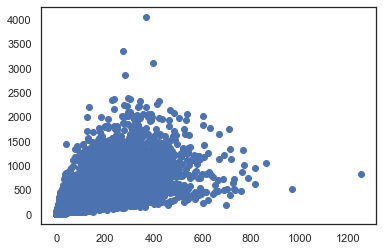

In [24]:
plt.scatter(x2,y2)

In [25]:
reg = linear_model.LinearRegression()
reg.fit(x2, y2)

LinearRegression()

In [26]:
w, w0 = reg.coef_, reg.intercept_
print(w, w0)

[1.65073665] 176.47580675529508


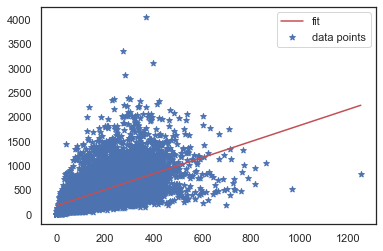

In [27]:
plt.scatter(x2, y2, marker='*', label='data points')
x_f = np.linspace(x2.min(), x2.max(), 10)
y_f = w0 + w[0] * x_f
plt.plot(x_f, y_f, label='fit', c='r')
plt.legend()
plt.show()

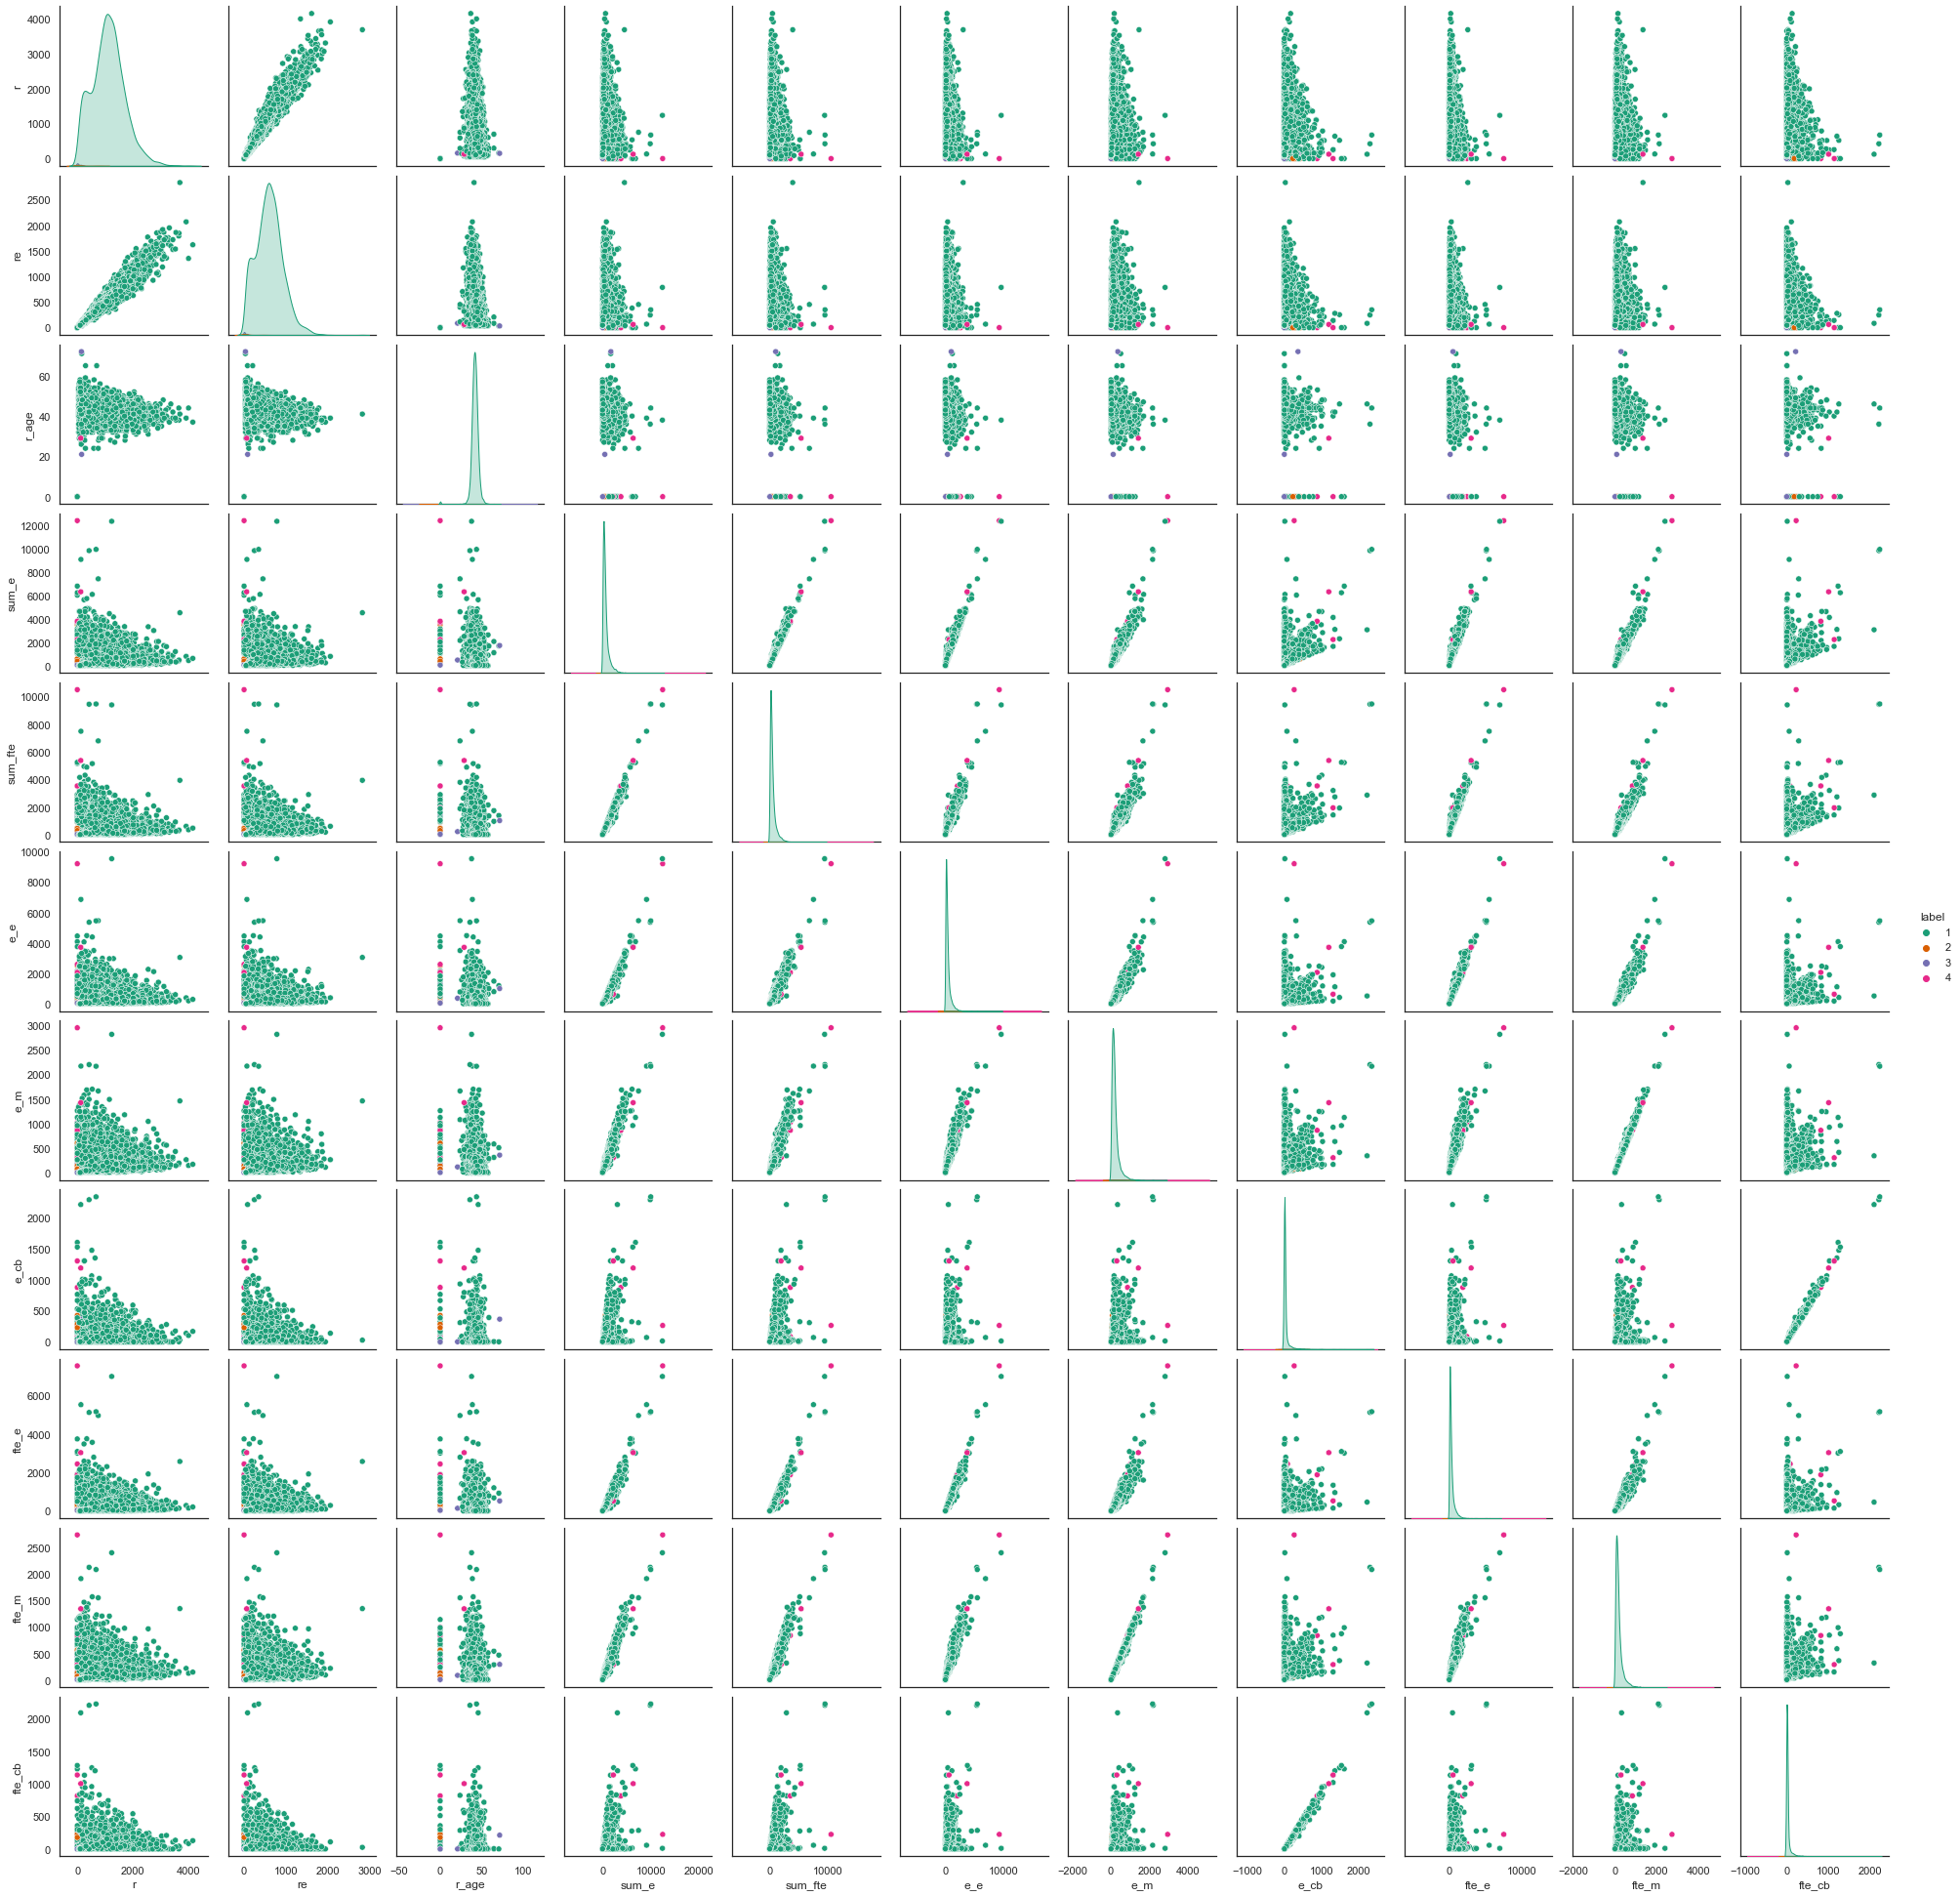

Wall time: 2min 19s


In [28]:
%%time
# Predict Zone Type
column_names_to_use = [
 'r'   
,'re'
,'r_age'
,'sum_e'
,'sum_fte'
,'e_e'
,'e_m'
,'e_cb'
,'fte_e'
,'fte_m'
,'fte_cb'
,'stg_type']

#relationship between total subscriptions and people commuting due to jobs in respect to different zones
df_co_analysis = df_strukturdaten[column_names_to_use].rename(columns={'stg_type':'label'}).astype('int32')
pair_plot = sns.pairplot( df_co_analysis , hue= 'label', diag_kind="kde", diag_kws=dict(shade=True), palette='Dark2')
plt.show()

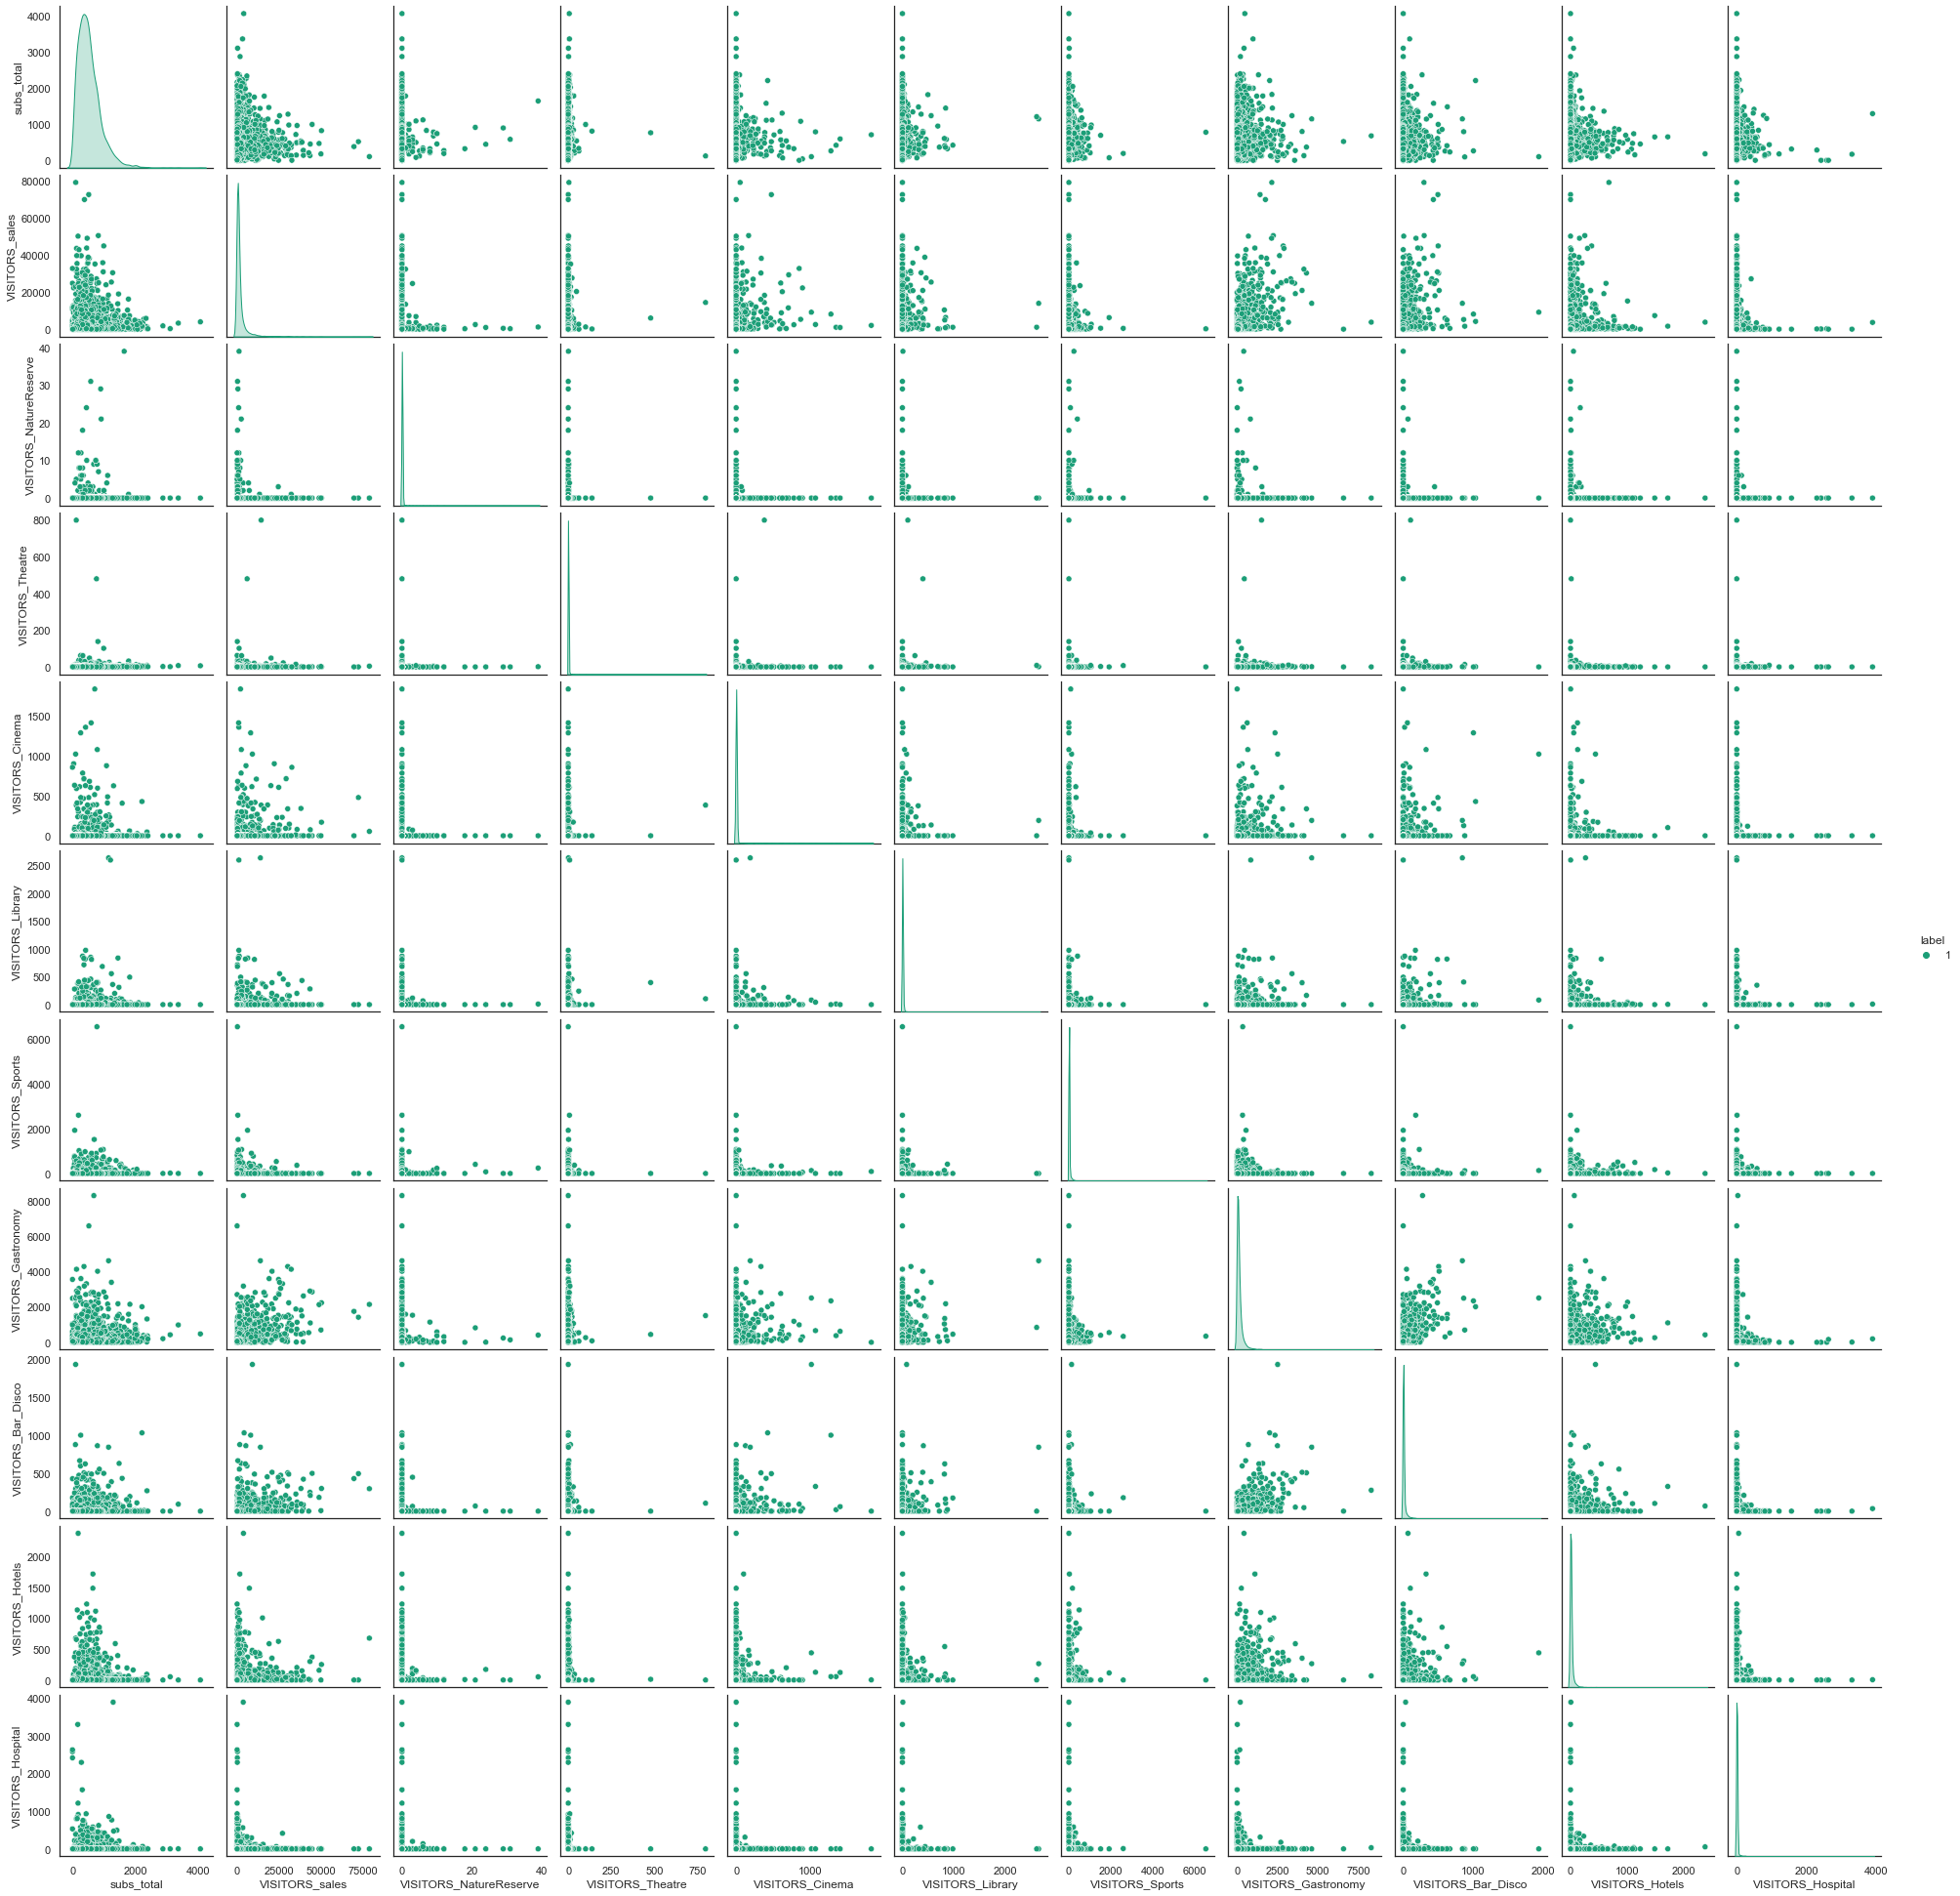

Wall time: 2min 14s


In [29]:
%%time
#relationship between total subscriptions and visitors in different areas of zone
column_names_to_use = [
 'subs_total'
,'VISITORS_sales'
,'VISITORS_NatureReserve'
,'VISITORS_Theatre'
,'VISITORS_Cinema'
,'VISITORS_Library'
#,'VISITORS_Museum'
#,'VISITORS_histBuilding'
,'VISITORS_Sports'
#,'VISITORS_Fitness'
,'VISITORS_Gastronomy'
,'VISITORS_Bar_Disco'
,'VISITORS_Hotels'
,'VISITORS_Hospital'
,'stg_type']

df_co_analysis = df_strukturdaten[df_strukturdaten.stg_type==1][column_names_to_use].rename(columns={'stg_type':'label'}).astype('int32')

pair_plot = sns.pairplot( df_co_analysis , hue= 'label', diag_kind="kde", diag_kws=dict(shade=True), palette='Dark2')
plt.show()

In [30]:
#renaming columns
# As they would appear in order in the final dataframe, top to down
#   old name                 ->  new name
cols = {
    'npvmid'                   : "Zone Id",
    'stg_type'                 : "Zone_Type",
    'munid'                    : "Municipality_Id",
    'Municipality'             : "Municipality_Name",
    'msrid'                    : "Gemeinde_Id",
    'N_Gem'                    : "Gemeinde_Name",
    'cantid'                   : "Canton_Id",
    'Canton'                   : "Canton_Name",
    # Inhibitant Numbers
    "r"                        : "Number_Of_Inhabitants",
    "r_age"                    : "Inhabitant_Average_Age",
    'R_MALEP'                  : "Number_Of_Inhabitants_Male",
    'R_FEMALEP'                : "Number_Of_Inhabitants_FeMale",
    "R_06_24"                  : "Number_Of_Inhabitants_Aged_06-24",
    "R_18_44"                  : "Number_Of_Inhabitants_Aged_18-44",
    'R_INCOME'                 : "Inhabitant_Average_Income",
    # Travel                   
    'R_CARAVBL'                : "Number_Of_Inhabitants_With_Car",
    'R_CAROWNER'               : "Number_Of_Inhabitants_With_Own_Car",
    'R_COMPANYCAR'             : "Number_Of_Inhabitants_With_Company_Car",
    'subs_total'               : "Number_Of_Inhabitants_With_SBB_Abo",
    'R_HT'                     : "Number_Of_Inhabitants_With_SBB_HalbTax",
    'R_GATC'                   : "Number_Of_Inhabitants_With_SBB_GA",
    'R_LTC'                    : "Number_Of_Inhabitants_With_SBB_Regional_Abo",
    # Segments                 
    'R_0017_CARNOTC'           : "Inhabitants_Under_17_With_Car_No_Abo",
    'R_1824_CARNOTC'           : "Inhabitants_18-24_With_Car_No_Abo",
    'R_2544_CARNOTC'           : "Inhabitants_25-44_With_Car_No_Abo",
    'R_4564_CARNOTC'           : "Inhabitants_45-64_With_Car_No_Abo",
    'R_6574_CARNOTC'           : "Inhabitants_65-74_With_Car_No_Abo",
    'R_75XX_CARNOTC'           : "Inhabitants_Over_75_With_Car_No_Abo",
    'R_0017_CARTC'             : "Inhabitants_Under_17_With_Car_And_Abo",
    'R_1824_CARTC'             : "Inhabitants_18-24_With_Car_And_Abo",
    'R_2544_CARTC'             : "Inhabitants_25-44_With_Car_And_Abo",
    'R_4564_CARTC'             : "Inhabitants_45-64_With_Car_And_Abo",
    'R_6574_CARTC'             : "Inhabitants_65-74_With_Car_And_Abo",
    'R_75XX_CARTC'             : "Inhabitants_Over_75_With_Car_And_Abo",
    'R_0017_NOCNOTC'           : "Inhabitants_Under_17_No_Car_No_Abo",
    'R_1824_NOCNOTC'           : "Inhabitants_18-24_No_Car_No_Abo",
    'R_2544_NOCNOTC'           : "Inhabitants_25-44_No_Car_No_Abo",
    'R_4564_NOCNOTC'           : "Inhabitants_45-64_No_Car_No_Abo",
    'R_6574_NOCNOTC'           : "Inhabitants_65-74_No_Car_No_Abo",
    'R_75XX_NOCNOTC'           : "Inhabitants_Over_75_No_Car_No_Abo",
    'R_0017_NOCTC'             : "Inhabitants_Under_17_No_Car_With_Abo",
    'R_1824_NOCTC'             : "Inhabitants_18-24_No_Car_With_Abo",
    'R_2544_NOCTC'             : "Inhabitants_25-44_No_Car_With_Abo",
    'R_4564_NOCTC'             : "Inhabitants_45-64_No_Car_With_Abo",
    'R_6574_NOCTC'             : "Inhabitants_65-74_No_Car_With_Abo",
    'R_75XX_NOCTC'             : "Inhabitants_Over_75_No_Car_With_Abo",
    # Employeed Numbers        
    "re"                       : "Number_Of_Employees",
    "sum_e"                    : "Number_Of_Jobs",
    'e_a'                      : "Number_Of_Trainee_Jobs",
    'e_e'                      : "Number_Of_Non_Skill_Jobs",
    'e_m'                      : "Number_Of_Skill_Jobs",
    'e_cb'                     : "Number_Of_Cross_Border_Jobs",
    'fte_e'                    : "Number_Of_Non_Skill_employements",
    'fte_m'                    : "Number_Of_Skill_employements",
    'fte_cb'                   : "Number_Of_Cross_Border_employements",
    # Student                  
    "R_pupils"                 : "Number_Of_Schoolers",
    "pupils_I"                 : "Number_Of_Primary_Schoolers",
    "pupils_II"                : "Number_Of_Secondary_Schoolers",
    "pupils_II"                : "Number_Of_Secondary_Schoolers",
    "R_pupils_CAR"             : "Number_Of_Pupils_With_Car",
    "R_pupils_NOCTC"           : "Number_Of_Pupils_NoCar_But_SBB_Abo",
    "R_pupils_NOCNOTC"         : "Number_Of_Pupils_NoCar_And_No_SBB_Abo",
    "R_students"               : "Number_Of_Students",
    "R_students_CAR"           : "Number_Of_Students_With_Car",
    "R_students_NOC"           : "Number_Of_Students_Without_Car",
    # Visitors
    'VISITORS_sales'           : 'Daily_Shopping_Visits',
    'VISITORS_sales_st'        : 'Daily_Shopping_Visits_Short',
    'VISITORS_sales_lt'        : 'Daily_Shopping_Visits_Long',
    'DWVplus'                  : 'Daily_Staduim_Visits',
    'VISITORS_NatureReserve'   : 'Daily_Nature_Visits', 
    'VISITORS_Theatre'         : 'Daily_Theatre_Visits',
    'VISITORS_Cinema'          : 'Daily_Cinema_Visits',
    'VISITORS_Library'         : 'Daily_Library_Visits',
    'VISITORS_Museum'          : 'Daily_Museum_Visits',
    'VISITORS_histBuilding'    : 'Daily_Architecture_Visits',
    'VISITORS_Sports'          : 'Daily_Sport_Visits',
    'VISITORS_Fitness'         : 'Daily_Gym_Visits',
    'VISITORS_Gastronomy'      : 'Daily_Restaurant_Visits',
    'VISITORS_Bar_Disco'       : 'Daily_Bar_Disco_Visits',
    'VISITORS_Hotels'          : 'Daily_Hotel_Visits',
    'VISITORS_Hospital'        : 'Daily_Hospital_Visits',
    'VISITORS_Cableway_car'    : 'Daily_Cable_Car_Visits',
    'VISITORS_Leisure'         : 'Daily_Leisure_Visits',
    # not doing everything
    'RE_0017_CARNOTC'          : 'RE_0017_CARNOTC'     ,
    'RE_1824_CARNOTC'          : 'RE_1824_CARNOTC'     ,
    'RE_2544_CARNOTC'          : 'RE_2544_CARNOTC'     ,
    'RE_4564_CARNOTC'          : 'RE_4564_CARNOTC'     ,
    'RE_6574_CARNOTC'          : 'RE_6574_CARNOTC'     ,
    'RE_75XX_CARNOTC'          : 'RE_75XX_CARNOTC'     ,
    'RE_0017_CARTC'            : 'RE_0017_CARTC'       ,
    'RE_1824_CARTC'            : 'RE_1824_CARTC'       ,
    'RE_2544_CARTC'            : 'RE_2544_CARTC'       ,
    'RE_4564_CARTC'            : 'RE_4564_CARTC'       ,
    'RE_6574_CARTC'            : 'RE_6574_CARTC'       ,
    'RE_75XX_CARTC'            : 'RE_75XX_CARTC'       ,
    'RE_0017_NOCNOTC'          : 'RE_0017_NOCNOTC'     ,
    'RE_1824_NOCNOTC'          : 'RE_1824_NOCNOTC'     ,
    'RE_2544_NOCNOTC'          : 'RE_2544_NOCNOTC'     ,
    'RE_4564_NOCNOTC'          : 'RE_4564_NOCNOTC'     ,
    'RE_6574_NOCNOTC'          : 'RE_6574_NOCNOTC'     ,
    'RE_75XX_NOCNOTC'          : 'RE_75XX_NOCNOTC'     ,
    'RE_0017_NOCTC'            : 'RE_0017_NOCTC'       ,
    'RE_1824_NOCTC'            : 'RE_1824_NOCTC'       ,
    'RE_2544_NOCTC'            : 'RE_2544_NOCTC'       ,
    'RE_4564_NOCTC'            : 'RE_4564_NOCTC'       ,
    'RE_6574_NOCTC'            : 'RE_6574_NOCTC'       ,
    'RE_75XX_NOCTC'            : 'RE_75XX_NOCTC'       ,
    'RE_E_0017_CARNOTC'        : 'RE_E_0017_CARNOTC'   ,
    'RE_E_1824_CARNOTC'        : 'RE_E_1824_CARNOTC'   ,
    'RE_E_2544_CARNOTC'        : 'RE_E_2544_CARNOTC'   ,
    'RE_E_4564_CARNOTC'        : 'RE_E_4564_CARNOTC'   ,
    'RE_E_6574_CARNOTC'        : 'RE_E_6574_CARNOTC'   ,
    'RE_E_75XX_CARNOTC'        : 'RE_E_75XX_CARNOTC'   ,
    'RE_E_0017_CARTC'          : 'RE_E_0017_CARTC'     ,
    'RE_E_1824_CARTC'          : 'RE_E_1824_CARTC'     ,
    'RE_E_2544_CARTC'          : 'RE_E_2544_CARTC'     ,
    'RE_E_4564_CARTC'          : 'RE_E_4564_CARTC'     ,
    'RE_E_6574_CARTC'          : 'RE_E_6574_CARTC'     ,
    'RE_E_75XX_CARTC'          : 'RE_E_75XX_CARTC'     ,
    'RE_E_0017_NOCNOTC'        : 'RE_E_0017_NOCNOTC'   ,
    'RE_E_1824_NOCNOTC'        : 'RE_E_1824_NOCNOTC'   ,
    'RE_E_2544_NOCNOTC'        : 'RE_E_2544_NOCNOTC'   ,
    'RE_E_4564_NOCNOTC'        : 'RE_E_4564_NOCNOTC'   ,
    'RE_E_6574_NOCNOTC'        : 'RE_E_6574_NOCNOTC'   ,
    'RE_E_75XX_NOCNOTC'        : 'RE_E_75XX_NOCNOTC'   ,
    'RE_E_0017_NOCTC'          : 'RE_E_0017_NOCTC'     ,
    'RE_E_1824_NOCTC'          : 'RE_E_1824_NOCTC'     ,
    'RE_E_2544_NOCTC'          : 'RE_E_2544_NOCTC'     ,
    'RE_E_4564_NOCTC'          : 'RE_E_4564_NOCTC'     ,
    'RE_E_6574_NOCTC'          : 'RE_E_6574_NOCTC'     ,
    'RE_E_75XX_NOCTC'          : 'RE_E_75XX_NOCTC'     ,
    'RE_M_0017_CARNOTC'        : 'RE_M_0017_CARNOTC'   ,
    'RE_M_1824_CARNOTC'        : 'RE_M_1824_CARNOTC'   ,
    'RE_M_2544_CARNOTC'        : 'RE_M_2544_CARNOTC'   ,
    'RE_M_4564_CARNOTC'        : 'RE_M_4564_CARNOTC'   ,
    'RE_M_6574_CARNOTC'        : 'RE_M_6574_CARNOTC'   ,
    'RE_M_75XX_CARNOTC'        : 'RE_M_75XX_CARNOTC'   ,
    'RE_M_0017_CARTC'          : 'RE_M_0017_CARTC'     ,
    'RE_M_1824_CARTC'          : 'RE_M_1824_CARTC'     ,
    'RE_M_2544_CARTC'          : 'RE_M_2544_CARTC'     ,
    'RE_M_4564_CARTC'          : 'RE_M_4564_CARTC'     ,
    'RE_M_6574_CARTC'          : 'RE_M_6574_CARTC'     ,
    'RE_M_75XX_CARTC'          : 'RE_M_75XX_CARTC'     ,
    'RE_M_0017_NOCNOTC'        : 'RE_M_0017_NOCNOTC'   ,
    'RE_M_1824_NOCNOTC'        : 'RE_M_1824_NOCNOTC'   ,
    'RE_M_2544_NOCNOTC'        : 'RE_M_2544_NOCNOTC'   ,
    'RE_M_4564_NOCNOTC'        : 'RE_M_4564_NOCNOTC'   ,
    'RE_M_6574_NOCNOTC'        : 'RE_M_6574_NOCNOTC'   ,
    'RE_M_75XX_NOCNOTC'        : 'RE_M_75XX_NOCNOTC'   ,
    'RE_M_0017_NOCTC'          : 'RE_M_0017_NOCTC'     ,
    'RE_M_1824_NOCTC'          : 'RE_M_1824_NOCTC'     ,
    'RE_M_2544_NOCTC'          : 'RE_M_2544_NOCTC'     ,
    'RE_M_4564_NOCTC'          : 'RE_M_4564_NOCTC'     ,
    'RE_M_6574_NOCTC'          : 'RE_M_6574_NOCTC'     ,
    'RE_M_75XX_NOCTC'          : 'RE_M_75XX_NOCTC'     
}

In [31]:
df_final = df_strukturdaten[cols.keys()].rename(columns=cols)
df_final

,Zone Id,Zone_Type,Municipality_Id,Municipality_Name,Gemeinde_Id,Gemeinde_Name,Canton_Id,Canton_Name,Number_Of_Inhabitants,Inhabitant_Average_Age,...,RE_M_2544_NOCNOTC,RE_M_4564_NOCNOTC,RE_M_6574_NOCNOTC,RE_M_75XX_NOCNOTC,RE_M_0017_NOCTC,RE_M_1824_NOCTC,RE_M_2544_NOCTC,RE_M_4564_NOCTC,RE_M_6574_NOCTC,RE_M_75XX_NOCTC
0,101001,1,1,Knonaueramt,4,Aeugst am Albis,1,Zürich,1949,43,...,0,0,0,1,0,1,2,7,1,1
1,201001,1,2,Knonaueramt,4,Affoltern am Albis,1,Zürich,1238,40,...,5,7,0,0,0,2,3,2,0,0
2,201002,1,2,Knonaueramt,4,Affoltern am Albis,1,Zürich,407,49,...,1,0,0,0,0,0,1,1,0,0
3,201003,1,2,Knonaueramt,4,Affoltern am Albis,1,Zürich,1314,44,...,6,11,1,0,0,1,3,3,0,0
4,201004,1,2,Knonaueramt,4,Affoltern am Albis,1,Zürich,1195,44,...,19,10,1,1,0,2,5,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7961,681001001,1,6810,Jura,106,La Baroche,26,Jura,424,42,...,0,1,0,0,0,0,0,0,0,0
7962,681001002,1,6810,Jura,106,La Baroche,26,Jura,152,41,...,0,0,0,0,0,0,0,0,0,0
7963,681001003,1,6810,Jura,106,La Baroche,26,Jura,185,48,...,1,1,0,0,0,0,0,0,0,0
7964,681001004,1,6810,Jura,106,La Baroche,26,Jura,312,46,...,1,1,0,0,0,0,0,0,0,0


In [32]:
df_final = df_strukturdaten[cols.keys()].rename(columns=cols)
df_final

,Zone Id,Zone_Type,Municipality_Id,Municipality_Name,Gemeinde_Id,Gemeinde_Name,Canton_Id,Canton_Name,Number_Of_Inhabitants,Inhabitant_Average_Age,...,RE_M_2544_NOCNOTC,RE_M_4564_NOCNOTC,RE_M_6574_NOCNOTC,RE_M_75XX_NOCNOTC,RE_M_0017_NOCTC,RE_M_1824_NOCTC,RE_M_2544_NOCTC,RE_M_4564_NOCTC,RE_M_6574_NOCTC,RE_M_75XX_NOCTC
0,101001,1,1,Knonaueramt,4,Aeugst am Albis,1,Zürich,1949,43,...,0,0,0,1,0,1,2,7,1,1
1,201001,1,2,Knonaueramt,4,Affoltern am Albis,1,Zürich,1238,40,...,5,7,0,0,0,2,3,2,0,0
2,201002,1,2,Knonaueramt,4,Affoltern am Albis,1,Zürich,407,49,...,1,0,0,0,0,0,1,1,0,0
3,201003,1,2,Knonaueramt,4,Affoltern am Albis,1,Zürich,1314,44,...,6,11,1,0,0,1,3,3,0,0
4,201004,1,2,Knonaueramt,4,Affoltern am Albis,1,Zürich,1195,44,...,19,10,1,1,0,2,5,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7961,681001001,1,6810,Jura,106,La Baroche,26,Jura,424,42,...,0,1,0,0,0,0,0,0,0,0
7962,681001002,1,6810,Jura,106,La Baroche,26,Jura,152,41,...,0,0,0,0,0,0,0,0,0,0
7963,681001003,1,6810,Jura,106,La Baroche,26,Jura,185,48,...,1,1,0,0,0,0,0,0,0,0
7964,681001004,1,6810,Jura,106,La Baroche,26,Jura,312,46,...,1,1,0,0,0,0,0,0,0,0


### reading file jobs_zones_images.csv and saving it to df_excel2. 
### df_zones is the same and has added another column 'Image', that has the zones images in 32x32 matrix and saved in a list


In [33]:
df_excel2   = pd.read_csv("data/jobs_zones_images.csv", header=0,sep=',', dtype=float )
df_excel2   = df_excel2.rename(columns={'Unnamed: 0':'Zone_id'})
df_zones    = df_excel2.iloc[:, :1].astype(int)  
df_zones['Image'] = np.reshape(np.array(df_excel2.iloc[:, 1:].values.tolist()), (-1, 32, 32)).tolist()
df_zones

,Zone_id,Image
0,101001,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,201001,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,201002,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,201003,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,201004,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
...,...,...
7960,681001002,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
7961,681001003,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
7962,681001004,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
7963,681001005,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [34]:
imdata = df_zones['Image']

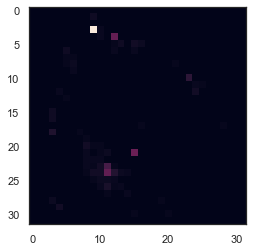

In [35]:
#images stored in imdata. showing the first image of first zone
from matplotlib import pyplot as plt
plt.imshow(imdata[0], interpolation='nearest')
plt.show()

In [36]:
#from the last strukturdaten dataframe, extracting columns zone id, no. of ihbaitants, no. of jobs and people with Abo.
#saving in new df_jobs

df_jobs = df_final[["Zone Id","Number_Of_Inhabitants","Number_Of_Jobs","Number_Of_Inhabitants_With_SBB_Abo"]]

In [37]:
#52 rows have columns with 0 value

df_jobs[df_jobs['Number_Of_Inhabitants']==0].count()

Zone Id                               52
Number_Of_Inhabitants                 52
Number_Of_Jobs                        52
Number_Of_Inhabitants_With_SBB_Abo    52
dtype: int64

In [38]:
#df_job_zones_images is the final dataframe with images and df_jobs data merged together. this data frame will be used now.

df_job_zones_images = df_zones.merge(df_jobs, left_on='Zone_id'  , right_on='Zone Id').drop(columns=['Zone Id'])
df_zones2 = df_excel2.merge(df_jobs, left_on='Zone_id'  , right_on='Zone Id').drop(columns=['Zone Id'])

In [39]:
df_job_zones_images.head()

,Zone_id,Image,Number_Of_Inhabitants,Number_Of_Jobs,Number_Of_Inhabitants_With_SBB_Abo
0,101001,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1949,465,1194.0
1,201001,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1238,301,622.0
2,201002,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",407,2520,274.0
3,201003,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1314,376,795.0
4,201004,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1195,903,686.0


In [40]:
df_job_zones_images.columns

Index(['Zone_id', 'Image', 'Number_Of_Inhabitants', 'Number_Of_Jobs',
       'Number_Of_Inhabitants_With_SBB_Abo'],
      dtype='object')

In [41]:
#i decided to convolve each image with scipy.signal's convolve2d, it convolves a 2d image to a number. this way, we convert 
#each image to a specific value which can give some meaning about the image to be used further for clustering


from scipy.signal import convolve2d

#kernal is a 3x3 matrix that will be multiplied with the image using function convolve2d
kernel = np.ones((3,3), np.float32)/3
kernel

array([[0.33333334, 0.33333334, 0.33333334],
       [0.33333334, 0.33333334, 0.33333334],
       [0.33333334, 0.33333334, 0.33333334]], dtype=float32)

In [42]:
#introducing a new column job_density which is a specific float number for each region, telling the density of job in that
#region. 

df_job_zones_images['Job_Density'] = df_job_zones_images.iloc[:,1].apply(lambda x: np.average(convolve2d(np.array(x), kernel, mode='same')))

In [43]:
# Remove outliers
df_job_zones_images = df_job_zones_images.drop(df_job_zones_images[df_job_zones_images.Job_Density > 2.6].index)

In [44]:
#min job density is 0.002, max is 1.17. 50% lies from 0 to 0.05 and the rest from 0.05 to 1.17.
#i would use this info to introduce levels of job density. we could give each region a level of low, medium, high job density
#or 0,1,2 respectively. based on the job density number that came from convolving images, showing what level of job density
#is there in each region

df_job_zones_images.Job_Density.describe()

count    7741.000000
mean        0.099884
std         0.132123
min         0.002930
25%         0.021036
50%         0.051815
75%         0.123208
max         1.179596
Name: Job_Density, dtype: float64

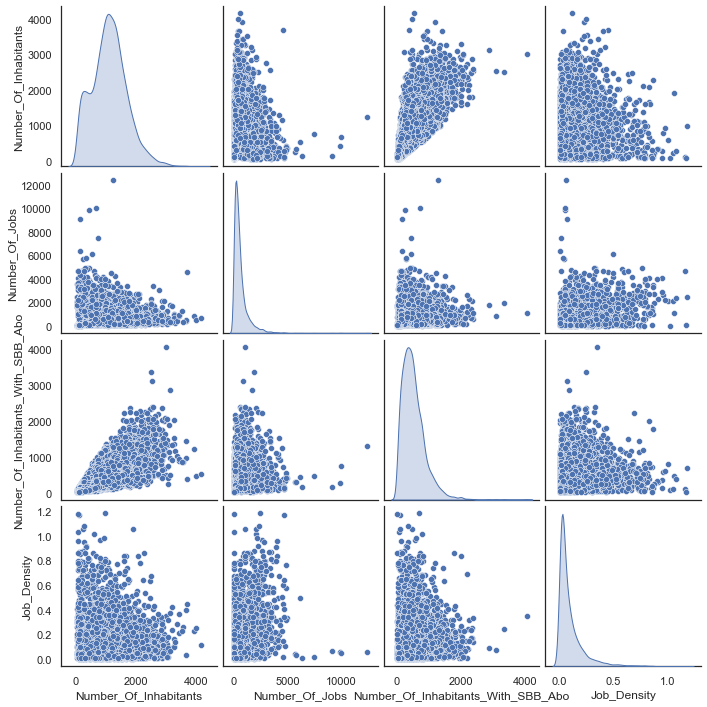

In [45]:
column_names_to_use = ['Number_Of_Inhabitants','Number_Of_Jobs','Number_Of_Inhabitants_With_SBB_Abo','Job_Density']
df_co_analysis = df_job_zones_images.fillna(0)[df_job_zones_images['Number_Of_Inhabitants']!=0][column_names_to_use].astype('float')

pair_plot = sns.pairplot( df_co_analysis , diag_kind="kde", diag_kws=dict(shade=True), palette='Dark2')
plt.show()

In [46]:
#new colulmn with job_density_lvl with 0(low density), 1(medium density), 2(high density)

df_job_zones_images['Job_Density_Lvl'] = df_job_zones_images['Job_Density'].apply(lambda x: '0' if x<0.15 else ('1' if x<0.4 else '2')).astype('int')

In [47]:
#updated dataframe

df_job_zones_images.describe()

,Zone_id,Number_Of_Jobs,Number_Of_Inhabitants_With_SBB_Abo,Job_Density,Job_Density_Lvl
count,7.744000e+03,7744.000000,7744.000000,7741.000000,7744.000000
mean,3.033413e+08,618.780992,517.896049,0.099884,0.240315
std,2.229570e+08,723.485045,358.460081,0.132123,0.513007
min,1.010010e+05,5.000000,0.000000,0.002930,0.000000
25%,8.497600e+07,199.000000,262.750000,0.021036,0.000000
50%,2.831010e+08,403.000000,455.000000,0.051815,0.000000
75%,5.199260e+08,749.250000,691.000000,0.123208,0.000000
max,6.810010e+08,12431.000000,4059.000000,1.179596,2.000000


In [48]:
df_job_zones_images

,Zone_id,Image,Number_Of_Inhabitants,Number_Of_Jobs,Number_Of_Inhabitants_With_SBB_Abo,Job_Density,Job_Density_Lvl
0,101001,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1949,465,1194.0,0.011225,0
1,201001,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1238,301,622.0,0.055687,0
2,201002,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",407,2520,274.0,0.137661,0
3,201003,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1314,376,795.0,0.083548,0
4,201004,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1195,903,686.0,0.358398,1
...,...,...,...,...,...,...,...
7746,681001001,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",424,91,75.0,0.050379,0
7747,681001002,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",152,33,37.0,0.097013,0
7748,681001003,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",185,69,37.0,0.010386,0
7749,681001004,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",312,192,59.0,0.004791,0


In [49]:
df_zones = df_job_zones_images

In [61]:
#### CLUSTERING

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import ParameterGrid
from sklearn.cluster import KMeans

#taking dataframe df_zones because it has a 1024 image not 32x32 matrix. we now need a flatten image with 1024 cols
df_cluster = df_zones2.copy().merge(df_job_zones_images[['Zone_id','Job_Density_Lvl']]).fillna(0)
#df_cluster    = df_excel2.rename(columns={'Unnamed: 0':'Zone_id'}).iloc[:, :1].astype(int)
col_x = list(df_cluster.columns)

#col_x will have no. of inhabitants, no. of jobs, people with Abo, and image
col_x.remove('Zone_id')
col_x.remove('Job_Density_Lvl')
col_y = 'Job_Density_Lvl'

In [62]:
X = df_cluster[col_x]
X

,0,1,2,3,4,5,6,7,8,9,...,1017,1018,1019,1020,1021,1022,1023,Number_Of_Inhabitants,Number_Of_Jobs,Number_Of_Inhabitants_With_SBB_Abo
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1949,465,1194.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1238,301,622.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,407,2520,274.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1314,376,795.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1195,903,686.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7739,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,424,91,75.0
7740,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,152,33,37.0
7741,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,185,69,37.0
7742,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,312,192,59.0


In [63]:
y_true = df_cluster[col_y]
y_true

0       0
1       0
2       0
3       0
4       1
       ..
7739    0
7740    0
7741    0
7742    0
7743    1
Name: Job_Density_Lvl, Length: 7744, dtype: int32

In [64]:
# Scaling the data to keep the different attributes in same range.
X = StandardScaler().fit_transform(X)
X

array([[ 0.        ,  0.        ,  0.        , ...,  1.43913798,
        -0.21256959,  1.88625636],
       [ 0.        ,  0.        ,  0.        , ...,  0.22731331,
        -0.4392648 ,  0.29043868],
       [ 0.        ,  0.        ,  0.        , ..., -1.18903874,
         2.6280319 , -0.6804434 ],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., -1.56741438,
        -0.75995557, -1.34164758],
       [ 0.        ,  0.        ,  0.        , ..., -1.35095624,
        -0.58993417, -1.28026998],
       [ 0.        ,  0.        ,  0.        , ..., -1.70547035,
        -0.82630539, -1.41976453]])

In [65]:
#applying pca to all x columns, we only want a 2 point output. each row being represented by a point with(x and y) so we could plot
#it and show as part of a cluster. with pca, each whole row is now represented by a single point with two values.
pca_2 = PCA(n_components=2)
X = pca_2.fit_transform(X) 
X

array([[-7.21550074,  0.21145723],
       [-3.55055739, -0.88647808],
       [ 3.25356781, -1.64251909],
       ...,
       [-7.344146  , -0.24425834],
       [-7.83922414,  0.05159036],
       [ 7.80852859,  6.07652966]])

In [66]:
#we want to have 3 clusters of X
k = 3
kmeans = KMeans(n_clusters=k)
kmeans.fit(X)
y_kmeans = kmeans.predict(X) #predicting X and saving to y_kmeans
idx = np.argsort(kmeans.cluster_centers_.sum(axis=1)) #max count is 0, so everytime max count is assigned 0, min to 2
lut = np.zeros_like(idx) 
lut[idx] = np.arange(k) 
y_kmeans = lut[y_kmeans] 

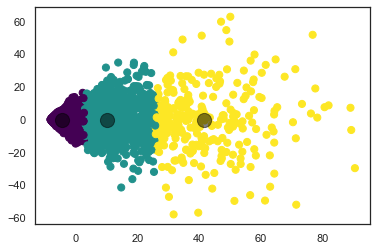

In [67]:
# predicted Ckusters
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

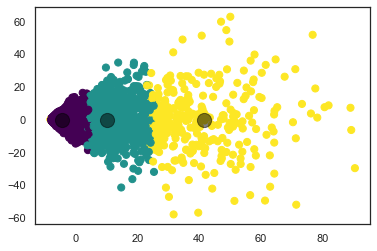

In [68]:
# Actual Clusters
plt.scatter(X[:, 0], X[:, 1], c=y_true, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

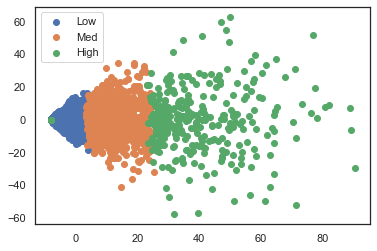

In [69]:
# Predicted clusters with actual labels
fig, ax = plt.subplots()
group = y_true
names = {0: 'Low', 1: 'Med', 2: 'High'}
for g in np.unique(group):
    i = np.where(group == g)
    ax.scatter(X[i, 0], X[i, 1],label=names[g])
ax.legend()
plt.show()

In [70]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true, y_kmeans)

0.9677169421487604

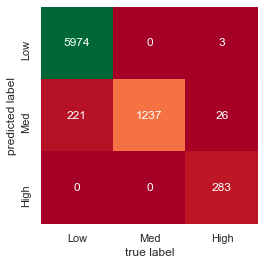

In [71]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_true, y_kmeans)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap="RdYlGn",
            xticklabels=names.values(),
            yticklabels=names.values())
plt.xlabel('true label')
plt.ylabel('predicted label');